In [1]:
import itertools

import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import seaborn as sns
import astropy.io.fits as pyfits
import re
import ctypes
import glob
import pandas as pd
import scipy.optimize as opt
import subprocess as sbp
import seaborn as sns
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy as sp
import scipy.ndimage



%matplotlib inline

In [2]:
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
      - wf [float]:  width fraction in columnwidth units
      - hf [float]:  height fraction in columnwidth units.
                     Set by default to golden ratio.
      - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                             using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]

In [3]:
def make_SpAdj(file_Name, omega_limit, direct = False, return_disorder = False):
    hdulist = pyfits.open(file_Name);
    
    B1 = hdulist[0].header['HIERARCH LATTICE NSITES B1'];
    B2 = hdulist[0].header['HIERARCH LATTICE NSITES B2'];
    num_sites = B1*B2;
    
    disorder_fraction = hdulist[0].header['HIERARCH HUBBARD MODEL V FRACTION'];
    
    adj_mat = np.zeros([num_sites, num_sites]);
    
    omega = hdulist['ParamagneticSusceptibility_1'].header['HIERARCH PIPELINE CGS OMEGA'];
    
    if omega > omega_limit:
        raise Exception('Omega is below threshold for DC-Conductivity Extrapolation')
    
    bonds = np.array( hdulist['HoppingBonds'].data );
    para_susc = np.array(hdulist['ParamagneticSusceptibility_1'].data);
    para_xx = 1000 * np.abs(bonds['DisplacementX']) * ((para_susc['ParamagneticSusceptibilityXUp']) + (para_susc['ParamagneticSusceptibilityXDn']))
    para_yy = 1000 * np.abs(bonds['DisplacementY']) * ((para_susc['ParamagneticSusceptibilityYUp']) + (para_susc['ParamagneticSusceptibilityYDn']))
    
    xbonds = bonds[np.where(np.abs(bonds['DisplacementX']) > 0.0)];
    ybonds = bonds[np.where(np.abs(bonds['DisplacementY']) > 0.0)];
    
    para_xx_redux = para_xx[np.where(np.abs(bonds['DisplacementX']) > 0.0)];
    para_yy_redux = para_yy[np.where(np.abs(bonds['DisplacementY']) > 0.0)];
    
    for bx, by, chix, chiy in zip(xbonds, ybonds, para_xx_redux, para_yy_redux):
        i_site_x = bx[0]-1;
        j_site_x = bx[1]-1;
        
        i_site_y = by[0]-1;
        j_site_y = by[1]-1;

        imag_chix = np.imag(chix);
        weight_x = 1.0 / imag_chix;
        imag_chiy = np.imag(chiy);
        weight_y = 1.0 / imag_chiy;
        
        if imag_chix < 0:
            i_site_x, j_site_x = j_site_x, i_site_x;
            
        if imag_chiy < 0:
            i_site_y, j_site_y = j_site_y, i_site_y;
        
        adj_mat[i_site_x, j_site_x] = np.abs(weight_x);
        adj_mat[i_site_y, j_site_y] = np.abs(weight_y);
        
        #### ****For undirected graph construction**** ####
        if direct == False:
            adj_mat[j_site_x, i_site_x] = np.abs(weight_x);
            adj_mat[j_site_y, i_site_y] = np.abs(weight_y);
    
    if return_disorder == False:
        return sp.sparse.csr_matrix(adj_mat);
    else:
        return sp.sparse.csr_matrix(adj_mat), disorder_fraction;

In [8]:
cd /Volumes/Balrog/Percolation/

/Volumes/Balrog/Percolation


In [9]:
VF_FRACTION = np.array([0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]);

size = 28;
direct = '.';

path_lists = np.zeros([VF_FRACTION.size, 1]);
path_lists = path_lists.tolist();
    
path_avg = np.zeros([VF_FRACTION.size]);
path_std = np.zeros([VF_FRACTION.size]);

#fraction_distance = np.zeros([VF_FRACTION.size]);
fraction_files = np.zeros([VF_FRACTION.size]);

for files in glob.iglob(direct + '/Perc_disint_30_*.fits'):
    
    distance = 0.0;
    
    sp_graph, disorder = make_SpAdj(files, 0.03, return_disorder=True);
    dist_matrix = sp.sparse.csgraph.shortest_path(csgraph=sp_graph, directed=False);
    
    index = int(np.where(np.abs(VF_FRACTION - disorder) < 0.01)[0]);
    
    for i in range(size):
        path_lists[index].append(dist_matrix[i][size//2 * size + (size//2 + i)%size]);
    
    #fraction_distance[index] += distance;
    fraction_files[index] += 1;
    
for j in range(VF_FRACTION.size):
    path_avg[j] = np.mean(path_lists[j][1::]);
    path_std[j] = np.std(path_lists[j][1::]);
    
fraction_distance = path_avg;

In [10]:
fraction_files

array([ 8.,  7.,  4., 11., 13., 13., 13., 13., 13., 13.])

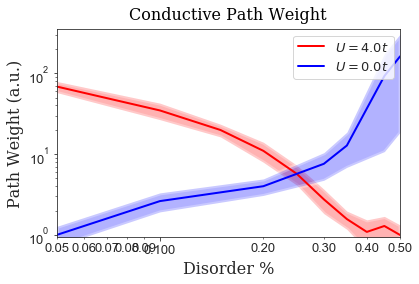

In [43]:
from matplotlib.ticker import ScalarFormatter

sns.set_style('ticks')

scale = 0.5

columnwidth = 342.2953 # value given by Latex
#fig = plt.figure(figsize=get_figsize(columnwidth, wf=1.5, hf=0.65))

SMALL_SIZE = scale * 35
MEDIUM_SIZE = scale * 48
BIGGER_SIZE = scale * 50

title_font = {'fontname':'serif', 'size':scale * 32, 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space

axis_font_x = {'fontname':'serif', 'size': scale * 32}
axis_font_y = {'fontname':'serif', 'size': scale * 32}

plt.rcParams.update({'font.size': scale * 30})
#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=scale * 26)     # fontsize of the axes title
plt.rc('xtick', labelsize=scale * 26)    # fontsize of the tick labels
plt.rc('ytick', labelsize=scale * 26)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.figure(figsize=get_figsize(columnwidth, wf=1.3, hf=0.62))

plt.plot(0.01, np.max(path_lists[0][1::]) / fraction_distance[-1], '.')
plt.plot(0.01, np.min(path_lists_nonint[0][1::]) / fraction_distance_nonint[0], '.')
plt.plot(VF_FRACTION, fraction_distance / fraction_distance[-1], label = r'$U = 4.0t$', color = 'r', linewidth=2.0)
plt.fill_between(VF_FRACTION, (fraction_distance-path_std) / fraction_distance[-1], (fraction_distance+path_std) / fraction_distance[-1],
    alpha=0.3, facecolor='r',
    linewidth=4, antialiased=True)
#indices = np.where(fraction_distance_nonint > 0.0);
#print indices
plt.plot(VF_FRACTION_nonint, fraction_distance_nonint / fraction_distance_nonint[0], label = r'$U = 0.0t$', color = 'b', linewidth=2.0)
plt.fill_between(VF_FRACTION_nonint, (fraction_distance_nonint-path_std_nonint) / fraction_distance_nonint[0], (fraction_distance_nonint+path_std_nonint) / fraction_distance_nonint[0],
    alpha=0.3, facecolor='b',
    linewidth=4, antialiased=True)
plt.loglog()
#plt.semilogy()
plt.xlim(0.05, .50)
plt.ylim(0.95, 350)
plt.xlabel('Disorder %', **axis_font_y)
plt.legend(loc = 1, prop={'size': scale * 26})
plt.ylabel('Path Weight (a.u.)', **axis_font_y)
#plt.grid(color='grey', linestyle='--', linewidth=0.25);
plt.title('Conductive Path Weight', **title_font);
ax = plt.gca()
ax.loglog()
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_formatter(formatter)
plt.savefig('/Users/Sazbo/Desktop/Trivedi_Group/mm19/path_length.pdf', bbox_inches = 'tight')


In [28]:
fig_ax[0].set

In [11]:
VF_FRACTION_nonint = np.array([0.05, 0.10, 0.20, 0.30, 0.35, 0.45, 0.50]);

size = 30;
direct = '.';

path_lists_nonint = np.zeros([VF_FRACTION_nonint.size, 1]);
path_lists_nonint = path_lists_nonint.tolist();
    
path_avg_nonint = np.zeros([VF_FRACTION_nonint.size]);
path_std_nonint = np.zeros([VF_FRACTION_nonint.size]);

#fraction_distance = np.zeros([VF_FRACTION.size]);
fraction_files = np.zeros([VF_FRACTION_nonint.size]);

for files in glob.iglob(direct + '/Perc_dis_30_*.fits'):
    
    distance = 0.0;
    
    sp_graph, disorder = make_SpAdj(files, 0.03, return_disorder=True);
    dist_matrix = sp.sparse.csgraph.shortest_path(csgraph=sp_graph, directed=False);
    
    index = int(np.where(np.abs(VF_FRACTION_nonint - disorder) < 0.01)[0]);
    
    for i in range(size):
        path_lists_nonint[index].append(dist_matrix[i][size//2 * size + (size//2 + i)%30]);
    
    #fraction_distance[index] += distance;
    fraction_files[index] += 1;
    
for j in range(VF_FRACTION_nonint.size):
    path_avg_nonint[j] = np.mean(path_lists_nonint[j][1::]);
    path_std_nonint[j] = np.std(path_lists_nonint[j][1::]);
    
fraction_distance_nonint = path_avg_nonint;

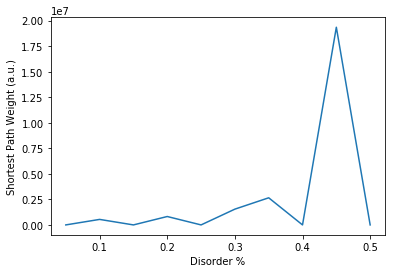

In [153]:
plt.plot(VF_FRACTION, fraction_distance_nonint)
plt.xlabel('Disorder %')
plt.ylabel('Shortest Path Weight (a.u.)')

#fraction_distance_nonint

In [222]:
hdulist = pyfits.open('Perc_disint_30_0_000.fits')
hdulist[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
HIERARCH LATTICE BASIS1 X ANGS = 1.000000E+00 / X-component of first unit cell b
HIERARCH LATTICE BASIS1 Y ANGS = 0.000000E+00 / Y-component of first unit cell b
HIERARCH LATTICE BASIS2 X ANGS = 0.000000E+00 / X-component of second unit cell 
HIERARCH LATTICE BASIS2 Y ANGS = 1.000000E+00 / Y-component of second unit cell 
HIERARCH LATTICE NSITES B1 = 28 / Number of lattice sites along b1              
HIERARCH LATTICE NSITES B2 = 28 / Number of lattice sites along b2              
HIERARCH LATTICE NSITES TOTA

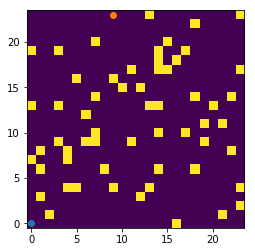

In [107]:
temp = pyfits.open(filename)
dm = np.array(temp["OnSiteImpurityPotential"].data)
plt.imshow(dm, origin='lower')
plt.scatter(0,0)
plt.scatter(561%24,561//24)
temp.close()

In [76]:
distance_test, pred = sp.sparse.csgraph.shortest_path(csgraph=comp_test, directed=False, indices=0, return_predecessors=True);

In [77]:
np.where(distance_test == np.max(distance_test))

(array([561]),)

In [113]:
distance_test[575], pred[301]

(13843.777525503581, 300)

In [11]:
cd ~

/Users/Sazbo


In [143]:
VF_FRACTION = np.array([0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]);

size = 30;
direct = '.';

fraction_distance = np.zeros([VF_FRACTION.size]);
fraction_files = np.zeros([VF_FRACTION.size]);

for files in glob.iglob(direct + '/Perc_disint_30_*.fits'):
    
    distance = 0.0;
    
    sp_graph, disorder = make_SpAdj(files, 0.03, return_disorder=True);
    dist_matrix = sp.sparse.csgraph.shortest_path(csgraph=sp_graph, directed=False);
    
    index = np.where(np.abs(VF_FRACTION - disorder) < 0.01);
    
    for i in range(size):
        distance += dist_matrix[i][size//2 * size + (size//2 + i)%24];
    
    fraction_distance[index] += distance;
    fraction_files[index] += 1;

In [26]:
hdulist.close(all)

NameError: name 'hdulist' is not defined

In [27]:
cd ~

/Users/Sazbo
